In [9]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd 
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from lime import lime_image
from skimage.segmentation import mark_boundaries
import numpy as np
import matplotlib.pyplot as plt
from skimage.io import imread

In [10]:
import torch
import torch.nn as nn
from torchvision import models
import timm

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model = timm.create_model('convnext_base', pretrained=False, num_classes=3)
model.load_state_dict(torch.load("models/convnext_base_best.pth", map_location=device))
model.to(device)
model.eval()

/var/folders/fz/sd4mlm5j5xq82d0vlcyb4sgm0000gn/T/ipykernel_5335/3326658765.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("models/convn

ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): Mlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (norm): Identity()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), g

In [11]:
from torchvision import transforms
from PIL import Image

# Preprocessing (must match training)
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Load an image
img_path = "covid_qu_ex_masked/test/COVID-19/covid_1582.png"
image = Image.open(img_path).convert("RGB")
input_tensor = transform(image).unsqueeze(0).to(device)

# Predict
with torch.no_grad():
    outputs = model(input_tensor)
    probs = torch.softmax(outputs, dim=1)[0]
    pred_class = torch.argmax(probs).item()

classes = ["COVID-19", "Non-COVID", "Normal"]
print("Prediction:", classes[pred_class])
print("Probabilities:", probs.tolist())

Prediction: COVID-19
Probabilities: [0.9999945163726807, 5.532595423574094e-06, 3.0339691869940566e-10]


# image-covid19

In [25]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from torchvision import transforms
from PIL import Image
import cv2  # for resizing the CAM


def apply_gradcam(model, img_path, target_layer, class_names):
    """
    Grad-CAM CPU version for ConvNeXt with shape fix.
    Ensures CAM and input image dimensions match before overlay.
    """
    device_cpu = torch.device("cpu")

    # Move model temporarily to CPU
    model_cpu = model.to(device_cpu)
    model_cpu.eval()

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )
    ])

    img = Image.open(img_path).convert("RGB")
    rgb_img = np.array(img.resize((224, 224))) / 255.0  # ensure same size
    input_tensor = transform(img).unsqueeze(0).to(device_cpu)

    cam = GradCAM(model=model_cpu, target_layers=[target_layer])

    with torch.no_grad():
        outputs = model_cpu(input_tensor)
        probs = torch.softmax(outputs, dim=1)[0]
        pred_class = torch.argmax(probs).item()

    # Compute Grad-CAM
    grayscale_cam = cam(input_tensor=input_tensor, targets=[ClassifierOutputTarget(pred_class)])
    grayscale_cam = grayscale_cam[0, :]

    # Resize CAM to match RGB image
    grayscale_cam = cv2.resize(grayscale_cam, (rgb_img.shape[1], rgb_img.shape[0]))

    # Overlay CAM
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.title(f"Original - {class_names[pred_class]}")
    plt.imshow(rgb_img)
    plt.axis("off")

    plt.subplot(1, 2, 2)
    plt.title("Grad-CAM Heatmap")
    plt.imshow(visualization)
    plt.axis("off")
    plt.show()

    # Move back to MPS for further work
    model.to(torch.device("mps" if torch.backends.mps.is_available() else "cpu"))

    return probs.numpy(), class_names[pred_class]


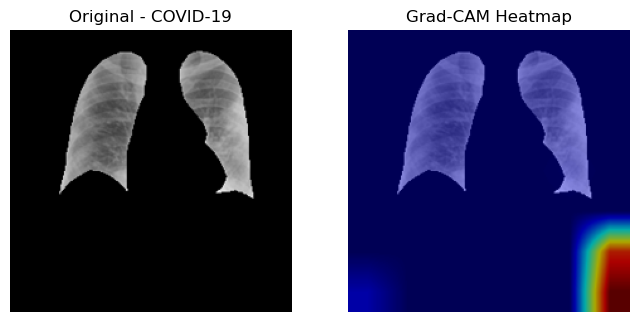

Predicted Label: COVID-19
Probabilities: [9.9999452e-01 5.5326695e-06 3.0340158e-10]


In [26]:
# Class labels
class_names = ["COVID-19", "Non-COVID", "Normal"]

# Target layer for Grad-CAM (last conv layer in ConvNeXt)
target_layer = model.stages[3].blocks[-1].conv_dw

# Test image path
img_path = "covid_qu_ex_masked/test/COVID-19/covid_1582.png"

# Apply Grad-CAM
probs, pred_label = apply_gradcam(model, img_path, target_layer, class_names)
print("Predicted Label:", pred_label)
print("Probabilities:", probs)

# for multiple layers

In [30]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
import cv2


def compare_gradcam_layers_convnext(model, img_path, transform, class_idx=0):
    """
    Compare Grad-CAM outputs across multiple layers of ConvNeXt.
    Works on CPU or MPS. Visualizes shallow → deep activations.
    """
    device = torch.device("cpu")  # Grad-CAM works more reliably on CPU (no MPS gradient issues)
    model.to(device)
    model.eval()

    # 🔹 Load & preprocess image
    rgb_img = np.float32(Image.open(img_path).convert("RGB").resize((224, 224))) / 255.0
    input_tensor = transform(Image.fromarray((rgb_img * 255).astype(np.uint8))).unsqueeze(0).to(device)

    # 🔹 Representative layers from each ConvNeXt stage
    candidate_layers = {
        # Stage 0 (early edges/textures)
        "Stage 0 - Block 0": model.stages[0].blocks[0].conv_dw,
        "Stage 0 - Block 2": model.stages[0].blocks[-1].conv_dw,

        # Stage 1 (shapes, contours)
        "Stage 1 - Block 0": model.stages[1].blocks[0].conv_dw,
        "Stage 1 - Block 2": model.stages[1].blocks[-1].conv_dw,

        # Stage 2 (core semantic building)
        "Stage 2 - Block 3": model.stages[2].blocks[3].conv_dw,
        "Stage 2 - Block 9": model.stages[2].blocks[9].conv_dw,
        "Stage 2 - Block 15": model.stages[2].blocks[15].conv_dw,
        "Stage 2 - Block 21": model.stages[2].blocks[21].conv_dw,
        "Stage 2 - Block 26": model.stages[2].blocks[26].conv_dw,

        # Stage 3 (final discriminative features)
        "Stage 3 - Block 0": model.stages[3].blocks[0].conv_dw,
        "Stage 3 - Block 2": model.stages[3].blocks[-1].conv_dw,
    }

    targets = [ClassifierOutputTarget(class_idx)]  # Class to visualize (0 = COVID-19)
    n_layers = len(candidate_layers)
    n_cols = 2
    n_rows = int(np.ceil((n_layers + 1) / n_cols))

    plt.figure(figsize=(14, n_rows * 5))

    # 🔹 Original Image
    plt.subplot(n_rows, n_cols, 1)
    plt.title("Original Image")
    plt.imshow(rgb_img)
    plt.axis("off")

    # 🔹 Generate Grad-CAM for each stage
    for idx, (name, layer) in enumerate(candidate_layers.items(), start=2):
        cam = GradCAM(model=model, target_layers=[layer])
        grayscale_cam = cam(input_tensor=input_tensor, targets=targets)[0, :]

        # Resize CAM to match image size
        grayscale_cam = cv2.resize(grayscale_cam, (rgb_img.shape[1], rgb_img.shape[0]))

        # Normalize
        grayscale_cam = (grayscale_cam - np.min(grayscale_cam)) / (np.max(grayscale_cam) - np.min(grayscale_cam) + 1e-8)

        visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)

        plt.subplot(n_rows, n_cols, idx)
        plt.title(name)
        plt.imshow(visualization)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


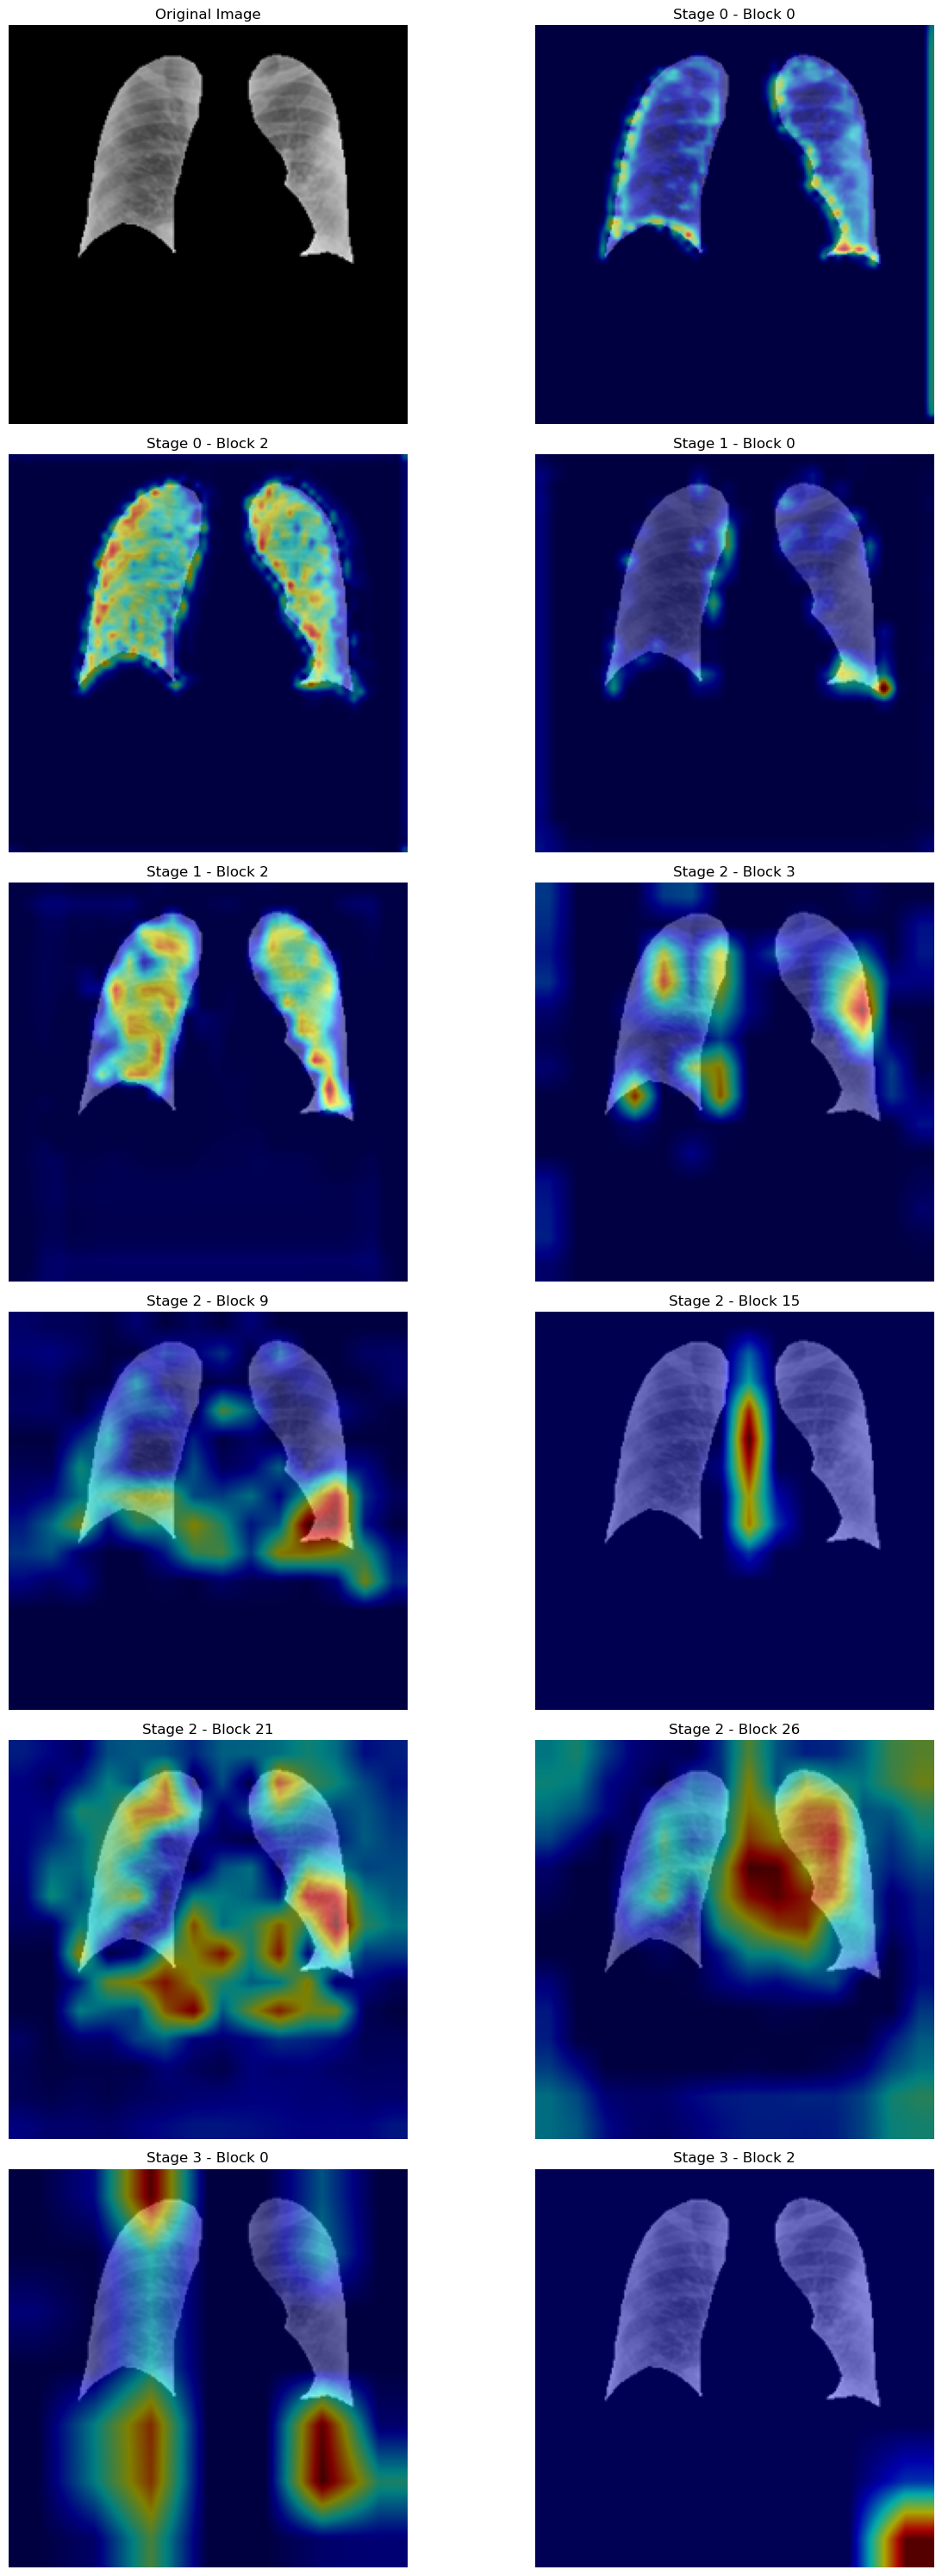

In [37]:
from torchvision import transforms

# Same preprocessing as training
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

# Image path
img_path = "covid_qu_ex_masked/test/COVID-19/covid_1582.png"

# Class names and index
class_names = ["COVID-19", "Non-COVID", "Normal"]
class_idx = 0  # 0 = COVID-19

compare_gradcam_layers_convnext(model, img_path, transform, class_idx=class_idx)